# 1 Introduction and Overview of PP-OCR System

The first two chapters mainly introduce the DBNet text detection algorithm and CRNN text recognition algorithm. However, for an image in our actual scene, if we want to be based on the text detection or recognition model alone, it is impossible to obtain the text position and text content at the same time. Therefore, we connect the text detection algorithm and the text recognition algorithm in series to construct the PP- OCR text detection and recognition system. In the actual use process, the detected text direction may not be the direction we expected, which will eventually lead to text recognition errors. Therefore, we have also introduced a direction classifier in the PP-OCR system.

This chapter mainly introduces the PP-OCR text detection and recognition system and the optimization strategies involved in the system. Through the study of this lesson, you can obtain:

* PaddleOCR strategy tuning skills
* Optimization techniques and optimization methods for text detection, recognition, and direction classifier models

The PP-OCR system has undergone a total of 2 optimizations. The following is a brief introduction to the PP-OCR system and these 2 optimizations.

## 1.1 Introduction to PP-OCR System and Optimization Strategy

In PP-OCR, if you want to extract text information from an image, you need to complete the following steps:

* Use the text detection method to obtain the polygon information of the text area (the text detection in PP-OCR uses DBNet, so the four-point information is obtained).
* Perform cropping and perspective transformation correction on the above-mentioned text polygon area, convert the text area into a rectangular box, and then use the direction classifier to correct the direction.
* Perform text recognition based on the rectangular box containing the text area, and get the final recognition result.

The above has completed the text detection and recognition process for an image.

The system block diagram of PP-OCR is shown below.

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/9665bc66a29346d9bf04ef2f664cf488da855a37da2249a3975b809e5e9038c4" align="middle" width = "1200"/>
<p align="center">
<center>Figure 1: PP-OCR system block diagram</center>

Text detection is based on DBNet with a relatively simple post-processing scheme. Text region correction mainly uses geometric transformation and direction classifiers. Text recognition uses a CRNN model based on fusion of convolution and sequence features. CTC loss is used to solve the inconsistency of prediction results and labels. problem.

PP-OCR uses a total of 19 strategies from the backbone network, learning rate strategy, data augmentation, model tailoring and quantification, etc., to optimize and slim the model, and finally create a server-oriented PP-OCR server system and a mobile-oriented PP -OCR mobile system.

## 1.2 Introduction to PP-OCRv2 System and Optimization Strategy

Compared with PP-OCR, PP-OCRv2 further optimizes the three aspects of backbone network, data augmentation, and loss function to solve the problems of poor end-to-side prediction efficiency, complex background, and misrecognition of similar characters. At the same time, it introduces The knowledge distillation training strategy further improves the accuracy of the model. specifically:

* Detection model optimization: (1) Adopt CML collaborative mutual learning knowledge distillation strategy; (2) CopyPaste data augmentation strategy;
* Recognition model optimization: (1) PP-LCNet lightweight backbone network; (2) U-DML improved knowledge distillation strategy; (3) Enhanced CTC loss loss function improvement.

From the effect point of view, there are three main improvements:

* In terms of model effect, compared to the PP-OCR mobile version, it has increased by over 7%;
* In terms of speed, compared to the PP-OCR server version, an increase of more than 220%;
* In terms of model size, with a total size of 11.6M, both server and mobile terminals can be easily deployed.

The comparison chart of the accuracy, prediction time, and model size between the PP-OCRv2 model and the previous PP-OCR series models is shown below.

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/18952983582a4a86853aab4c74e3c429dc0c5ab99f4c48eeb1b28cb0a174aa23" align="middle" width = "800"/>
<p align="center">
<center>Figure 2: Comparison of speed, accuracy and model size between PP-OCRv2 and PP-OCR</center>

The system block diagram of PP-OCRv2 is shown below.

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/ccd0d94112bc4adbb42645c71a9a91abeefe4015781646b88da9f223b2d3401f" align="middle" width = "1200"/>
<p align="center">
<center>Figure 3: PP-OCRv2 system block diagram</center>
  

This chapter will give a detailed interpretation of the above-mentioned PP-OCR and PP-OCRv2 system optimization strategies.

# 2 PP-OCR Optimization Strategy

The PP-OCR system includes a text detector, a direction classifier and a text recognizer. This section introduces the model optimization strategies in these three directions in detail.

## 2.1 Text Detection

The text detection in PP-OCR is based on the DBNet (Differentiable Binarization) model, which is based on the segmentation scheme, and the post-processing is simple. The specific model structure of DBNet is shown in the figure below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/33116a2a1f5a4c19b22f366d3f9a360083ff2d8fe7e343fea573eb22a0801143" width = "1200" />
</div>
<center>Figure 4: DBNet block diagram</center>

DBNet extracts features through the backbone, and uses the structure of DBFPN (neck) to fuse the features at each stage to obtain the fused features. The fused features are decoded by operations such as convolution (head) to generate a probability map and a threshold map. After the two are fused, an approximate binary map is calculated. When calculating the loss function, the loss function is calculated for these three feature maps. Here, the binary supervision is also added to the training process, so that the model can learn a more accurate boundary.

Six optimization strategies are used in DBNet to improve model accuracy and speed, including backbone network, feature pyramid network, head structure, learning rate strategy, model tailoring and other strategies. On the validation set, the conclusions of the ablation experiments for different modules are shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/a78fafbe853e410d9febb5ff412970081609f15a4059493f88c3aa6dc8278d25" width = "1000" />
</div>
<center>Figure 5: DBNet Ablation Experiment</center>


The detailed description is given below.

### 2.1.1 Lightweight Backbone Network

The size of the backbone network has an important influence on the model size of the text detector. Therefore, when constructing an ultra-lightweight detection model, a lightweight backbone network should be selected. With the development of image classification technology, MobileNetV1, MobileNetV2, MobileNetV3 and ShuffleNetV2 series are often used as lightweight backbone networks. Each series has a different model size and performance. [PaddeClas](https://github.com/PaddlePaddle/PaddleClas) provides more than 20 kinds of lightweight backbone networks. Their `Accuracy-Speed` curve on ARM is shown in the figure below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/d3855eac989542d49e5dd69e2f09de284ec02fd2c3314f8b9db7491630e0cd14" width = "800" />
</div>
<center>Figure 6: The "speed-accuracy" curve of the backbone network in PaddleClas</center>

In the case of the same prediction time, the MobileNetV3 series can achieve higher accuracy. In order to cover as many scenes as possible during the design, the author uses the parameter scale to adjust the number of feature map channels. The standard is 1x. If it is 0.5x, it means that the number of feature map channels in the network is 0.5 times that of the 1x corresponding network. . In order to further balance the accuracy and efficiency, in the size selection of V3, we adopted the structure of MobileNetV3_large 0.5x.

The following print out the feature map size of each stage of MobileNetV3 in DBNet.

In [ ]:
import os
import sys

# Download code
os.chdir("/home/aistudio/")
!git clone https://gitee.com/paddlepaddle/PaddleOCR.git
# Switch working directory
os.chdir("/home/aistudio/PaddleOCR/")
!pip install -U pip
!pip install -r requirements.txt

fatal: destination path 'PaddleOCR' already exists and is not an empty directory.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# The specific code implementation is located at:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/det_mobilenet_v3.py
import numpy as np
import paddle

# Set random input
inputs = np.random.rand(1, 3, 640, 640).astype(np.float32)
x = paddle.to_tensor(inputs)

# Import MobileNetV3 library
from ppocr.modeling.backbones.det_mobilenet_v3 import MobileNetV3

# Model definition
backbone_mv3 = MobileNetV3(scale=0.5, model_name='large')

# Model forward
bk_out = backbone_mv3(x)

# Model middle layer printing
for i, stage_out in enumerate(bk_out):
    print("the shape of ",i,'stage: ',stage_out.shape)

the shape of  0 stage:  [1, 16, 160, 160]
the shape of  1 stage:  [1, 24, 80, 80]
the shape of  2 stage:  [1, 56, 40, 40]
the shape of  3 stage:  [1, 480, 20, 20]


### 2.1.2 Lightweight Feature Pyramid Network DBFPN Structure

The feature fusion (neck) part of the text detector, DBFPN, is similar in structure to the FPN in the target detection task, fusing feature maps of different scales to improve the detection effect of text regions of different scales.

In order to facilitate the merging of feature maps of different channels, a convolution of `1×1` is used to reduce the feature maps to the same number of channels.

The probability map and the threshold map are generated by the feature map fused by convolution, and the convolution is also associated with inner_channels. Therefore, inner_channels has a great influence on the model size. When inner_channels is reduced from 256 to 96, the model size is reduced from 7M to 4.1M, and the speed is increased by 48%, but the accuracy is only slightly reduced.

The structure of DBFPN and the fusion result of the backbone network feature map are printed below.

In [ ]:
# The specific code implementation is located at:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/necks/db_fpn.py
from ppocr.modeling.necks.db_fpn import DBFPN

neck_bdfpn = DBFPN(in_channels=[16, 24, 56, 480], out_channels=96)
# Print DBFPN structure
print(neck_bdfpn)

# First reduce the number of original channels to 96, then to 24, and concat the last 4 feature maps
fpn_out = neck_bdfpn(bk_out)

print('the shape of output of DBFPN: ', fpn_out.shape)

DBFPN(
  (in2_conv): Conv2D(16, 96, kernel_size=[1, 1], data_format=NCHW)
  (in3_conv): Conv2D(24, 96, kernel_size=[1, 1], data_format=NCHW)
  (in4_conv): Conv2D(56, 96, kernel_size=[1, 1], data_format=NCHW)
  (in5_conv): Conv2D(480, 96, kernel_size=[1, 1], data_format=NCHW)
  (p5_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p4_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p3_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p2_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
)
the shape of output of DBFPN:  [1, 96, 160, 160]


### 2.1.3 SE Module Analysis in Backbone Network

SE is the abbreviation of `squeeze-and-excitation` (Hu, Shen, and Sun 2018). as the picture shows

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/9685731c2d65435b9fa6ede7e2dec5da77262d1f15704280a3207207e3946c7f" width = "1200" />
</div>
<center>Figure 7: Schematic diagram of SE module</center>

The SE block explicitly models the interdependence between the channels and adaptively recalibrates the channel characteristic response. The use of SE blocks in the network can significantly improve the accuracy of vision tasks. Therefore, the search space of MobileNetV3 includes SE modules, and finally MobileNetV3 also contains many SE modules. However, when the input resolution is large, such as `640×640`, it is difficult to estimate the characteristic response of the channel using the SE module, and the accuracy improvement is limited, but the time cost of the SE module is very high. In DBNet, **we remove the SE module from the backbone network**, and the model size is reduced from `4.1M` to `2.6M`, but the accuracy has no effect.

In PaddleOCR, you can remove the SE module in the backbone network by setting `disable_se=True`. The usage method is as follows.

In [ ]:
# The specific code implementation is located at:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/det_mobilenet_v3.py

x = paddle.rand([1, 3, 640, 640])

from ppocr.modeling.backbones.det_mobilenet_v3 import MobileNetV3

# Define model
backbone_mv3 = MobileNetV3(scale=0.5, model_name='large', disable_se=True)

# Model forward
bk_out = backbone_mv3(x)
# Output
for i, stage_out in enumerate(bk_out):
    print("the shape of ",i,'stage: ',stage_out.shape)

the shape of  0 stage:  [1, 16, 160, 160]
the shape of  1 stage:  [1, 24, 80, 80]
the shape of  2 stage:  [1, 56, 40, 40]
the shape of  3 stage:  [1, 480, 20, 20]


### 2.1.4 Learning Rate Strategy Optimization

* Cosine Learning Rate Reduction Strategy

The gradient descent algorithm requires us to set a value to control the weight update amplitude, which we call the learning rate. It is a hyperparameter that controls the learning speed of the model. The smaller the learning rate, the slower the change in loss. Although using a lower learning rate can ensure that no local minima is missed, it also means that the model converges slowly.

Therefore, in the early stage of training, the weights are in a random initialization state, and we can set a relatively large learning rate to speed up the convergence. In the later stage of training, the weight is close to the optimal value, and using a relatively small learning rate can prevent the model from oscillating during the convergence process.

The Cosine learning rate strategy also came into being. The Cosine learning rate strategy refers to the learning rate that changes according to the cosine curve during the training process. During the entire training process, the Cosine learning rate decay strategy enables the network to maintain a relatively large learning rate in the initial stage of training, and the learning rate will gradually decay to 0 in the later stage, and its convergence speed is relatively slow, but the final convergence accuracy is better. The figure below compares two different learning rate decay strategies `piecewise decay` and `cosine decay`.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/e9f48fda04c14d5787c0cea52f0e75d85b8f50aee70a4ee3adfc17da5158a72a" width = "800" />
</div>
<center>Figure 8: Cosine and Piecewise learning rate reduction strategy</center>

* Learning Rate Warm-up Strategy

When the model is first trained, the model weights are initialized randomly. At this time, if a larger learning rate is selected, the model training may be unstable. Therefore, the concept of **learning rate warm-up** is proposed to solve The problem of non-convergence in the initial stage of model training.

Learning rate warm-up refers to starting the learning rate from a small value and gradually increasing to the initial larger learning rate. It can ensure the stability of the model in the initial training stage. Using the learning rate warm-up strategy helps to improve the accuracy of image classification tasks. In DBNet, experiments show that this strategy is also effective. When the learning rate warm-up strategy is combined with the Cosine learning rate, the change trend of the learning rate is shown in the following code.

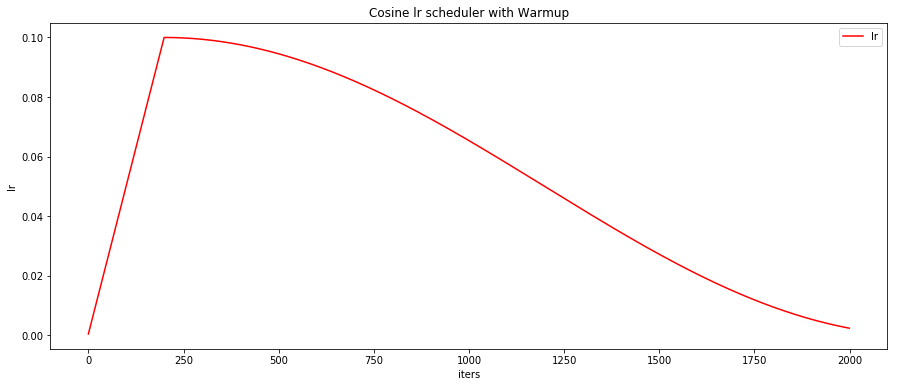

In [ ]:
# The specific code implementation is located in
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/optimizer/__init__.py
# Import the function built by the learning rate optimizer
from ppocr.optimizer import build_lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Let's also see the effect when warmup_epoch is 2h为2时的效果
lr_config = {'name': 'Cosine', 'learning_rate': 0.1, 'warmup_epoch': 2}
epochs = 20 # config['Global']['epoch_num']
iters_epoch = 100  # len(train_dataloader)
lr_scheduler=build_lr_scheduler(lr_config, epochs, iters_epoch)

iters = 0
lr = []
for epoch in range(epochs):
    for _ in range(iters_epoch):
        lr_sduler.step() # 对应 https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/program.py#L262
        iters += 1
        lr.append(lr_scheduler.get_lr())

x = np.arange(iters,dtype=np.int64)
y = np.array(lr,dtype=np.float64)

plt.figure(figsize=(15, 6))
plt.plot(x,y,color='red',label='lr')

plt.title(u'Cosine lr scheduler with Warmup')
plt.xlabel(u'iters')
plt.ylabel(u'lr')

plt.legend()

plt.show()

### 2.1.5 Model Tailoring Strategy-FPGM

Deep learning models generally have more parameter redundancy. We can use some methods to remove more redundant parts in the model, thereby improving the efficiency of model inference.

Model tailoring refers to obtaining a lighter network by removing redundant channels, filters, neurons, etc. in the network, while ensuring the accuracy of the model as much as possible.

Compared with the method of clipping the channel or the feature map, the method of clipping the filter can obtain a more regular model, thus reducing the memory consumption and accelerating the model inference process.

The previous cropping filter methods are mostly based on the norm. That is, the filter with a smaller norm is considered to be less important, but this method requires that the minimum norm of the existing filter should be close to 0, otherwise we It is difficult to remove.

To solve the above problems, Filter Pruning via Geometric Median (FPGM) is proposed. FPGM treats each filter in the convolutional layer as a point in Euclidean space, and it introduces the concept of geometric median, which is the point with the smallest sum of distances from all sampling points. If a filter is close to this geometric median, then we can think that the information of this filter overlaps with other filters and can be removed.

The comparison between FPGM and norm-based cropping algorithm is shown in the figure below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/13f84e7c4ce84d39b3e06adec20efed0e600dbfff1dc4db9b6498ba33d73925d" width = "800" />
</div>
<center>Figure 9: Schematic diagram of FPGM cropping</center>


In PP-OCR, we use FPGM to prune the detection model. In the end, the model accuracy of DBNet only slightly decreases, but the model size is reduced by 46%, and the prediction speed is accelerated by 19%.

For more details on the implementation of FPGM model clipping, please refer to [PaddleSlim](https://github.com/PaddlePaddle/PaddleSlim/blob/release/2.0.0/docs/zh_cn/api_cn/dygraph/pruners/fpgm_filter_pruner.rst#fpgmfilterpruner ).


**Notice:**

1. Model tailoring requires retraining the model, please refer to [PaddleOCR Pruning Tutorial](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.3/deploy/slim/prune/README.md).
2. The tailoring code is adapted according to DBNet. If you need to prune your own model, you need to re-analyze the model structure and the sensitivity of the parameters. We usually only recommend cutting the relatively low-sensitivity parameters, and skip allergies. Parameters with high sensitivity.
3. The pruning rate of each convolutional layer is also very important for the performance of the cropped model. Using exactly the same cropping rate for model cropping will usually result in significant performance degradation.
4. Model tailoring is not accomplished overnight, and repeated experiments are required to obtain a model that meets the requirements.

### 2.1.6 Description of Text Detection Configuration

A brief description of the training configuration of DBNet is given below, and the complete configuration file can be referred to:[ch_det_mv3_db_v2.0.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/det/ch_ppocr_v2.0/ch_det_mv3_db_v2.0.yml)。

```yaml
Architecture:                     # Model structure definition
   model_type: det
   algorithm: DB
   Transform:
   Backbone:
     name: MobileNetV3            # Configure backbone network
     scale: 0.5
     model_name: large
     disable_se: True             # Remove SE module
   Neck:
     name: DBFPN                  # Configure DBFPN
     out_channels: 96             # Configure inner_channels
   Head:
     name: DBHead
     k: 50

Optimizer:
   name: Adam
   beta1: 0.9
   beta2: 0.999
   lr:
     name: Cosine                 # Configure cosine learning rate reduction strategy
     learning_rate: 0.001         # Initial learning rate
     warmup_epoch: 2              # Configure learning rate warmup strategy
   regularizer:
     name:'L2'                    # Configure L2 regular
     factor: 0                    # The weight of the regular term
```

### 2.1.7 PP-OCR Detection Optimization Summary

The above introduced the optimization strategy of the text detection algorithm in PP-OCR, and here I will review the ablation experiments and conclusions corresponding to different optimization strategies.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/a78fafbe853e410d9febb5ff412970081609f15a4059493f88c3aa6dc8278d25" width = "1000" />
</div>
<center>Figure 10: DBNet Ablation Experiment</center>

Through strategies such as lightweight backbone network, lightweight neck structure, SE module analysis and removal, learning rate adjustment and optimization, and model tailoring, the model size of DBNet is reduced from **7M** to **1.5M**. Through training strategy optimization such as learning rate strategy optimization, DBNet's model accuracy has increased by more than **1%**.

In PP-OCR, the ultra-lightweight DBNet detection effect is as follows:

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/593321ac0ec34cd39ca4c3755de0bc6ee15b19d24ccc4fe7b37c194b7e825187" width = "800" />
</div>
<center>Figure 11: the ultra-lightweight DBNet detection results</center>

The following shows the prediction effect of quickly using the text detection model. The specific predictive reasoning code will be explained in detail in Chapter 5.

mkdir: cannot create directory ‘inference’: File exists
--2021-12-24 21:07:17--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  4.13MB/s    in 0.7s    

2021-12-24 21:07:18 (4.13 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

[2021/12/24 21:07:22] root INFO: 00111002.jpg	[[[78, 641], [408, 638], [408, 659], [78, 662]], [[76, 614], [214, 614], [214, 635], [76, 635]], [[103, 554], [150, 554], [150, 576], [103, 576]], [[74, 531], [349, 531], [349, 551], [74, 551]], [[75, 503], [310, 499], [311, 523], [75, 527]], [[162, 462], [320, 462], [320

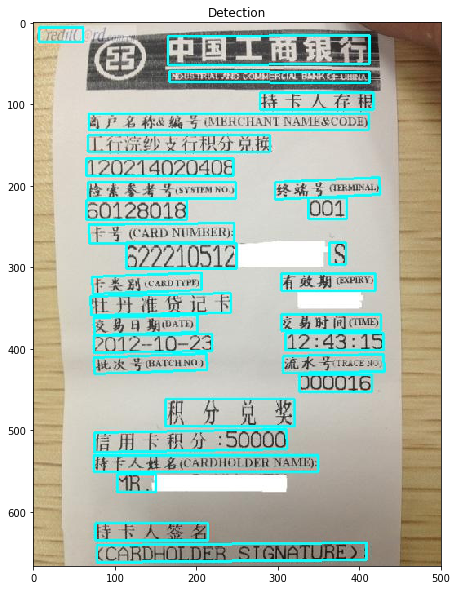

In [ ]:
!mkdir inference
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
!python tools/infer/predict_det.py --image_dir="./doc/imgs/00111002.jpg" --det_model_dir="./inference/ch_PP-OCRv2_det_infer" --use_gpu=False
from PIL import Image
img_det = Image.open('./inference_results/det_res_00111002.jpg')

plt.figure(figsize=(14, 10)) # window size
plt.imshow(img_det)
plt.axis('on')
plt.title('Detection')
plt.show()

## 2.2 Direction Classifier

The task of the direction classifier is to classify the direction of the text instance detected by the text, rotate the text to 0 degrees, and then send it to the subsequent text recognizer. In PP-OCR, we considered two directions of **0** degree and **180** degree. The following is a detailed introduction to the speed and accuracy optimization strategy for the direction classifier.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/65b6e5d75f22403aba50665a1ab6dbba51cdb47eff0845d1909e5e54fd48e336" width = "1200" />
</div>
<center>Figure 12: Directional classifier ablation experiment</center>

### 2.2.1 Lightweight Backbone Network

Same as the text detector, we still use MobileNetV3 as the backbone network of the direction classifier. Because the task of direction classification is relatively simple, we use MobileNetV3 small 0.35x to balance model accuracy and prediction efficiency. Experiments show that even when using a larger backbone, the accuracy will not be further improved.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/9177cfe7d294423e9f7e330d3c11ed4cafb46948305346a69a0edaee2b128890" width = "1000" />
</div>
<center>Figure 13: Comparison of the accuracy of direction classifiers under different backbone networks</center>

### 2.2.2 Data Enhancement

Data enhancement refers to transforming the image and sending it to the network for training, which can improve the generalization performance of the network. Commonly used data enhancement includes rotation, perspective distortion transformation, motion blur transformation and Gaussian noise transformation, etc. In PP-OCR, we collectively refer to these data enhancement methods as BDA (Base Data Augmentation). The results show that BDA can significantly improve the accuracy of the directional classifier.

The following shows the effect of some BDA data augmentation methods

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b78ce4772e684804bb22f20bf806dab2128793fd30e04e74b660f24dc636d68a" width = "1000" />
</div>
<center>Figure 14: BDA data augmentation effect</center>


In addition to BDA, we also added some higher-level data augmentation operations to improve the classification effect, such as AutoAugment (Cubuk et al. 2019), RandAugment (Cubuk et al. 2020), CutOut (DeVries and Taylor 2017), RandErasing (Zhong et al. 2020), HideAndSeek (Singh and Lee 2017), GridMask (Chen 2020), Mixup (Zhang et al. 2017) and Cutmix (Yun et al. 2019).

These data augmentations are divided into 3 categories:

(1) Image transformation category: AutoAugment, RandAugment

(2) Image cropping categories: CutOut, RandErasing, HideAndSeek, GridMask

(3) Image aliasing: Mixup, Cutmix

The visual comparison results of different high-level data augmentation are given below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/3d71ffaa2c3b4b7ebf7a39256d8607f205ce9a9e22eb4908bce75066a4a0f0f2" width = "1200" />
</div>
<center>Figure 15: High-level data augmentation visualization effect</center>


But experiments show that, except for RandAugment and RandErasing, most methods are not suitable for directional classifiers. The figure below also shows the changes in model accuracy under different data enhancement strategies.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0f85faaa6dd6429882e33827384a2d4fac9f4d8c3f804a249917779c97790e7c" width = "1000" />
</div>
<center>Figure 16: Ablation study of data augmentation for direction classication</center>

Finally, we combine BDA and RandAugment as a data enhancement strategy for the directional classifier during training.

* RandAugment code demo

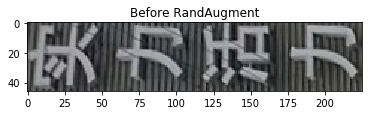

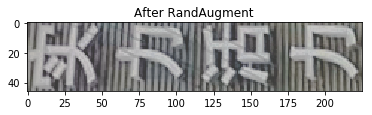

In [ ]:
# Reference Code:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/__init__.py
import random
from PIL import Image
from ppocr.data.imaug import DecodeImage, RandAugment, transform

np.random.seed(1)
random.seed(1)

img = Image.open('./doc/imgs_words/ch/word_4.jpg')

# Draw the original image
plt.figure("Image1") # Image window name
plt.imshow(img)
plt.axis('on') # Turn off the axis is off
plt.title('Before RandAugment') # image title
plt.show()


data = {'image':None}
with open('./doc/imgs_words/ch/word_4.jpg','rb') as f:
     img = f.read()
     data['image'] = img

# Define transformation operator
ops_list = [DecodeImage(), RandAugment()]

# Data transformation
data = transform(data,ops_list)

img_auged = data['image']

# show
img_auged = Image.fromarray(img_auged,'RGB')
plt.figure("Image") # Image window name
plt.imshow(img_auged)
plt.axis('on') # Turn off the axis is off
plt.title('After RandAugment') # image titleplt.title('After RandAugment') # Image title
plt.show()

The following shows the prediction effect of quickly using the direction classifier model. The specific predictive reasoning code will be explained in detail in [Chapter 5](../5.ppocrv2_inference_deployment/PP-OCRv2_prediction_deployment_practice.ipynb).

--2021-12-24 21:19:04--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1454080 (1.4M) [application/x-tar]
Saving to: ‘ch_ppocr_mobile_v2.0_cls_infer.tar’

ch_ppocr_mobile_v2. 100%[===================>]   1.39M  --.-KB/s    in 0.1s    

2021-12-24 21:19:04 (14.3 MB/s) - ‘ch_ppocr_mobile_v2.0_cls_infer.tar’ saved [1454080/1454080]

[2021/12/24 21:19:06] root INFO: Predicts of ./doc/imgs_words/ch/word_1.jpg:['0', 0.9998784]


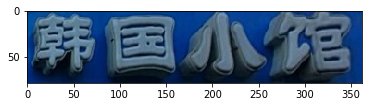

[2021/12/24 21:19:09] root INFO: Predicts of ./test.png:['180', 0.9999759]


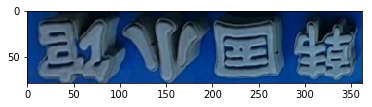

In [ ]:
# Reference Code:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_cls.py
!cd inference && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0.tars_infer

# Direction classifier classification
!python tools/infer/predict_cls.py --image_dir="./doc/imgs_words/ch/word_1.jpg" --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" --use_gpu=False

# Import image
import cv2
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

plt.imshow(img[:,:,::-1])
plt.show()

# Rotate 180 degrees
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite("./test.png", img)

# Use the direction classifier to classify the rotated image
!python tools/infer/predict_cls.py --image_dir="./test.png" --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" --use_gpu=False

plt.imshow(img[:,:,::-1])
plt.show()


### 2.2.3 Input Resolution Optimization

Generally speaking, when the input resolution of the image increases, the accuracy will also increase. Since the backbone network parameters of the direction classifier are very small, even if the resolution is increased, the reasoning time will not increase significantly. We increased the input image scale of the direction classifier from `3x32x100` to `3x48x192`, and the accuracy of the direction classifier increased from `92.1%` to `94.0%`, but the prediction time only increased from `3.19ms` to `3.21 ms`.

Below is a comparison of the image sizes at the two scales.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/7f7fbe95eb3a4d14ac6def76874ce27559436040b91840688337f9a9f72c1a8d" width = "1200" />
</div>
<center>Figure 17: Image size comparison between 32x100 and 48x192 scales</center>


### 2.2.4 Model Quantification Strategy-PACT

Model quantization is a technology that converts floating point calculations into low-rate specific point calculations, which can make neural network models have lower delay, smaller size, and lower computational power consumption.

Model quantification is mainly divided into offline quantification and online quantification. Among them, offline quantization refers to a fixed-point quantization method that uses methods such as KL divergence to determine quantization parameters, and does not require retraining after quantization; online quantization refers to determining quantization parameters during the training process. Compared with offline quantization mode, its The accuracy loss is smaller.

PACT (PArameterized Clipping acTivation) is a new online quantization method that can **remove some extreme values from the activation layer in advance**. After removing extreme values, the model can learn more appropriate quantitative parameters. The preprocessing of the activation value of the ordinary PACT method is based on the RELU function, and the formula is as follows:

$$
y=P A C T(x)=0.5(|x|-|x-\alpha|+\alpha)=\left\{\begin{array}{cc}
0 & x \in(-\infty, 0) \\
x & x \in[0, \alpha) \\
\alpha & x \in[\alpha,+\infty)
\end{array}\right.
$$

All activation values greater than a certain threshold will be reset to a constant. However, the activation function in MobileNetV3 is not only ReLU, but also hardswish. Therefore, the use of ordinary PACT quantization will lead to higher accuracy loss. Therefore, in order to reduce the quantization loss, we modify the formula of the activation function to:

$$
y=P A C T(x)=\left\{\begin{array}{rl}
-\alpha & x \in(-\infty,-\alpha) \\
x & x \in[-\alpha, \alpha) \\
\alpha & x \in[\alpha,+\infty)
\end{array}\right.
$$

PaddleOCR provides quantitative scripts suitable for PP-OCR kits. For specific links, please refer to [PaddleOCR Model Quantization Tutorial](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/deploy/slim/quantization/README.md).


### 2.2.5 Direction Classifier Configuration Instructions

When training the direction classifier, some key fields and descriptions in the configuration file are as follows. The complete configuration file can refer to [cls_mv3.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/cls/cls_mv3.yml).

```yaml
Architecture:
  model_type: cls
  algorithm: CLS
  Transform:
  Backbone:
    name: MobileNetV3 # Configure the classification model as MobileNetV3
    scale: 0.35
    model_name: small
  Neck:
  Head:
    name: ClsHead
    class_dim: 2

Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/cls
    label_file_list:
      -./train_data/cls/train.txt
    transforms:
      -DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      -ClsLabelEncode: # Class handling label
      -RecAug:
          use_tia: False # Configure BDA data enhancement without using TIA data enhancement
      -RandAugment: # Configure random enhancement data enhancement method
      -ClsResizeImg:
          image_shape: [3, 48, 192] # Here, [3, 32, 100] is changed to [3, 48, 192] to optimize the input resolution
      -KeepKeys:
          keep_keys: ['image','label'] # dataloader will return list in this order
  loader:
    shuffle: True
    batch_size_per_card: 512
    drop_last: True
    num_workers: 8
```

### 2.2.5 Experimental Summary of Directional Classifier

In the optimization of the direction classifier model, we use a lightweight backbone network and model quantization, and finally reduce the model from 0.85M** to 0.46M**, using combined data augmentation, high resolution and other features, and finally Improved model accuracy by more than **2%**. The comparison of ablation experiments is shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/65b6e5d75f22403aba50665a1ab6dbba51cdb47eff0845d1909e5e54fd48e336" width = "1200" />
</div>
<center>Figure 18: Directional classifier ablation experiment</center>


## 2.3 Text recognition

In PP-OCR, the text recognizer uses the CRNN model. When training, use CTC loss to solve the prediction problem of variable length text.

The structure of the CRNN model is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6c4f0d8e87de400691764107c7b1bd374c695a94d7de479da1c1de36a1cca238" width = "800" />
</div>
<center>Figure 19: CRNN structure diagram</center>

PP-OCR is aimed at the text recognizer and optimizes the model from multiple perspectives such as backbone network, head structure optimization, data enhancement, regularization strategy, feature map downsampling strategy, and quantification. The specific ablation experiment is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/44bcc2e797114171aaf584e4d7c79e19cf4ac1fc3e254ad7bdb5cbc01463c790" width = "800" />
</div>
<center>Figure 20: CRNN recognition model ablation experiment</center>

The specific optimization strategy of the text recognition model is described in detail below.


### 2.3.1 Lightweight Backbone Network and Head Structure

* Lightweight backbone network

In text recognition, MobileNetV3, which is the same as text detection, is still used as the backbone. Selected from MobileNetV3_small_x0.5 to further balance accuracy and efficiency. If the model size is not required, you can choose MobileNetV3_small_x1, the model size is only increased by 5M, and the accuracy is significantly improved.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6272a6cfdc7a431db44407c0e60c17abc259f8c83dc7422eb60ecb87f322a2e1" width = "800" />
</div>
<center>Figure 21: Comparison of recognition model accuracy under different backbone networks</center>

* Lightweight Head Structure

In CRNN, the lightweight head used for decoding is a fully connected layer used to decode sequence features into ordinary predicted characters. The dimension of the sequence feature has a great influence on the model size of the text recognizer, especially for the Chinese recognition scene with more than 6000 characters (if the sequence feature dimension is set to 256, the model size of only the head part is **6.7M **). In PP-OCR, we conducted experiments on the dimension of sequence features, and finally set it to 48, which balances accuracy and efficiency. The conclusions of some ablation experiments are as follows.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/e9f020c2748d4870b273a2c3ada03212d2791520baf949ac84b78429251bff2a" width = "600" />
</div>
<center>Figure 22: Accuracy comparison of feature dimensions of different sequences</center>


### 2.3.2 Data Enhancement

In addition to the aforementioned BDA (Basic Data Enhancement), which is often used for text recognition, TIA (Luo et al., 2020) is also an effective method for text recognition data enhancement. TIA is a data enhancement method for scene text. It sets multiple reference points in the image, and then randomly moves the points to generate new images through geometric transformation, which greatly improves the diversity of data and the generalization ability of the model. The basic flow chart of TIA is shown in the figure:

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/f7883b2263e64eaf853b9bf02fc2be5fb737aefd97e74a4db158943eae792a23" width = "600" />
</div>
<center>Figure 23: The basic flow chart of TIA</center>

Experiments show that the use of TIA data augmentation can help the accuracy of the text recognition model to be further improved by 0.9% on a very high baseline.

Below is the visualization of the three types of data augmentation involved in TIA.

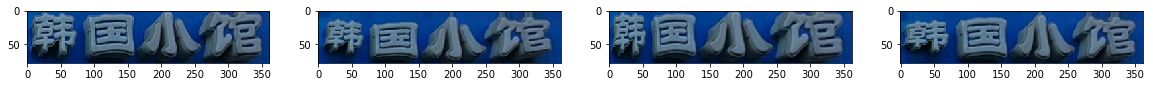

In [ ]:
# Reference Code:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/text_image_aug/augment.py
import cv2
from ppocr.data.imaug.rec_img_aug import tia_distort, tia_stretch, tia_perspective
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

img_out1 = tia_distort(img, 2.5)
img_out2 = tia_stretch(img, 3)
img_out3 = tia_perspective(img)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.imshow(img[:,:,::-1])
plt.subplot(1,4,2)
plt.imshow(img_out1[:,:,::-1])
plt.subplot(1,4,3)
plt.imshow(img_out2[:,:,::-1])
plt.subplot(1,4,4)
plt.imshow(img_out3[:,:,::-1])
plt.show()

### 2.3.3 Learning Rate Strategy and Regularization

In the training of the recognition model, the learning rate reduction strategy is the same as the text detection, and the learning rate strategy of Cosine+Warmup is also used.

Regularization is a widely used method to avoid overfitting, generally including L1 regularization and L2 regularization. In most usage scenarios, we use L2 regularization. Its main principle is to calculate the L2 norm of the weights in the network and add it to the loss function. With the help of L2 regularization, the weight of the network tends to choose a smaller value, and finally the parameters in the entire network tend to 0, thereby alleviating the over-fitting problem of the model and improving the generalization performance of the model.

Our experiments have found that for text recognition, L2 regularization has a great influence on the recognition accuracy.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/44bcc2e797114171aaf584e4d7c79e19cf4ac1fc3e254ad7bdb5cbc01463c790" width = "800" />
</div>
<center>Figure 24: CRNN recognition model ablation experiment</center>

### 2.3.4 Feature Map Downsampling Strategy

When we are doing downstream vision tasks such as detection, segmentation, OCR, the backbone network is generally the backbone network in the image classification task used, and its input resolution is generally set to 224x224. When downsampling, the width and height will generally decrease at the same time. sampling.

However, for text recognition tasks, since the input image is generally 32x100, the aspect ratio is very unbalanced. At this time, the width and height are downsampled at the same time, which will cause severe feature loss. Therefore, the backbone network in the image classification task is applied to text recognition The task needs to be adapted for feature map downsampling (**If you change the backbone network by yourself, you need to pay attention here**).

In PaddleOCR, the height and width of the input image set by the CRNN Chinese text recognition model are set to 32 and 320. The original MobileNetV3 comes from the classification model. As mentioned above, the step size of downsampling needs to be adjusted to adapt to the text image input resolution. Specifically, in order to retain more level information, we modify the step size of the down-sampling feature map from **(2,2)** to **(2,1)**, except for the first down-sampling. The final result is shown in the figure below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/330608b3e6114eb49172b83864bd1caf160a46be759349f3a89ee08e583e9f46" width = "800" />
</div>
<center>Figure 25: Optimization visualization of downsampling step strategy</center>

In order to retain more vertical information, we further modify the step size of the second downsampling feature map from **(2,1)** to **(1,1)**. Therefore, the step size s2 of the second down-sampling feature map will significantly affect the resolution of the entire feature map and the accuracy of the text recognizer. In PP-OCR, s2 is set to (1,1) to obtain better performance. At the same time, due to the increase in horizontal resolution, the inference time of the CPU has increased from `11.84ms` to `12.96ms`.

The following shows the comparison of the feature map scale before and after stride optimization. Although the final output feature map has the same scale, after stride is modified from (2,1) to (1,1), the feature information is preserved more complete in the encoding process.

In [ ]:
# Reference Code:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/rec_mobilenet_v3.py
from ppocr.modeling.backbones.rec_mobilenet_v3 import MobileNetV3

mv3_ori = MobileNetV3(model_name="small", scale=0.5, small_stride=[2,2,2,2])
mv3_new = MobileNetV3(model_name="small", scale=0.5, small_stride=[1,2,2,2])

x = paddle.rand([1, 3, 32, 320])

y_ori = mv3_ori(x)
y_new = mv3_new(x)

print(y_ori.shape)
print(y_new.shape)

[1, 288, 1, 80]
[1, 288, 1, 80]



### 2.3.5 PACT Online Quantitative Strategy

We use a scheme similar to the quantization of the direction classifier to reduce the model size of the text recognizer. Due to the complexity of LSTM quantization, LSTM is not quantized in PP-OCR. After using this quantification strategy, the model size is reduced by 67.4%, the prediction speed is accelerated by 8%, and the accuracy is increased by 1.6%. Quantization can reduce model redundancy and enhance the expressive ability of the model.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0840afd4a40c4cc39352287c18d6de57d47fe43587804c1baadb924894881397" width = "600"/>
</div>
<center>Figure 26: Model quantitative ablation experiment</center>

### 2.3.6 Text Recognition Pre-training Model

Using a suitable pre-trained model can speed up the convergence speed of the model. In real scenarios, the data used for text recognition is usually limited. In PP-OCR, we synthesized tens of millions of levels of data, trained the model, and then fine-tuned on the real data based on the model. The final recognition accuracy increased from `65.81%` to `69%`.

### 2.3.7 Description of Text Recognition Configuration

A brief description of the training configuration of CRNN is given below. The complete configuration file can be referred to: [rec_chinese_lite_train_v2.0.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/configs/rec/ch_ppocr_v2.0/rec_chinese_lite_train_v2.0.yml).


```yaml
Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine # Configure Cosine learning rate reduction strategy
    learning_rate: 0.001
    warmup_epoch: 5 # Configure warmup learning rate
  regularizer:
    name:'L2' # Configure L2 regular
    factor: 0.00001

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
  Backbone:
    name: MobileNetV3 # Configure Backbone
    scale: 0.5
    model_name: small
    small_stride: [1, 2, 2, 2] # Configure the stride for downsampling
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 48 # Configure the dimension of the last fully connected layer
  Head:
    name: CTCHead
    fc_decay: 0.00001
 
 Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/
    label_file_list: ["./train_data/train_list.txt"]
    transforms:
      -DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      -RecAug: # Configuration data enhancement BDA and TIA, TIA is used by default
      -CTCLabelEncode: # Class handling label
      -RecResizeImg:
          image_shape: [3, 32, 320]
      -KeepKeys:
          keep_keys: ['image','label','length'] # dataloader will return list in this order
  loader:
    shuffle: True
    batch_size_per_card: 256
    drop_last: True
    num_workers: 8
 ```

### 2.3.8 Summary of Identification and Optimization

In terms of model size, PP-OCR uses a lightweight backbone network, sequence dimension tailoring, and model quantification strategies to reduce the model size from 4.5M to 1.6M. In terms of accuracy, optimization strategies such as TIA data enhancement, Cosine-warmup learning rate strategy, L2 regularization, feature map resolution improvement, and pre-training model are used to finally improve the validation set by 15.4%.

Some of the recognition results by PP-OCR are shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/8da2664561ac47d2b3db3a9957fb81a39d5b8b06f85346a48fe4ac9fd6ff70b3" width = "600" />
</div>
<center>Figure 27: The recognition results by PP-OCR</center>

The code demonstration of the text recognition model is as follows.

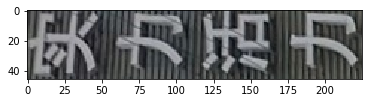

--2021-12-24 21:50:31--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===================>]   8.46M  24.2MB/s    in 0.4s    

2021-12-24 21:50:31 (24.2 MB/s) - ‘ch_PP-OCRv2_rec_infer.tar’ saved [8875520/8875520]

[2021/12/24 21:50:33] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409585)


In [ ]:
# Visualize the original image
img = cv2.imread("./doc/imgs_words/ch/word_4.jpg")
plt.imshow(img[..., ::-1])
plt.show()

!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar && tar -xf ch_PP-OCRv2_rec_infer.tar
!python tools/infer/predict_rec.py --image_dir="./doc/imgs_words/ch/word_4.jpg" --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" --use_gpu=False

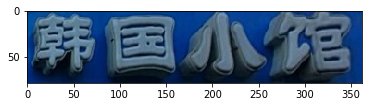

[2021/12/24 21:52:00] root INFO: Predicts of ././doc/imgs_words/ch/word_1.jpg:('韩国小馆', 0.9967349)


In [ ]:
import cv2
# Rotate ./doc/imgs_words/ch/word_1.jpg 180 degrees to get
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

plt.imshow(img[:,:,::-1])
plt.show()

!python tools/infer/predict_rec.py --image_dir="././doc/imgs_words/ch/word_1.jpg" --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" --use_gpu=False


# 3. Interpretation of PP-OCRv2 Optimization Strategy


Section 2 mainly introduces PP-OCR and its 19 optimization strategies in detail.

Compared with PP-OCR, PP-OCRv2 further optimizes the three aspects of backbone network, data augmentation, and loss function to solve the problems of poor end-to-side prediction efficiency, complex background, and misrecognition of similar characters. At the same time, it introduces The knowledge distillation training strategy further improves the accuracy of the model. specifically:

* Detection model optimization: (1) Adopt CML collaborative mutual learning knowledge distillation strategy; (2) CopyPaste data augmentation strategy;
* Recognition model optimization: (1) PP-LCNet lightweight backbone network; (2) U-DML improved knowledge distillation strategy; (3) Enhanced CTC loss loss function improvement.

This section is mainly based on the optimization process of text detection and recognition models to interpret the optimization strategy of PP-OCRv2.

## 3.1 Detailed Explanation of Text Detection Model Optimization

In the process of optimizing the text detection model, the CML collaborative mutual learning knowledge distillation and CopyPaste data augmentation strategy are adopted; the text detection model is finally increased from **0.759** to **0.795** under the condition that the size of the text detection model remains unchanged. The ablation experiment is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/71c31fc78946459d9b2b0a5aeae75e9bf784399a73554bc79f8c25716ed9dcbe" width = "800" />
</div>
<center>Figure 28: PP-OCRv2 detection model ablation experiment</center>

### 3.1.1 CML Knowledge Distillation Strategy

The knowledge distillation method is very commonly used in deployment. By using a large model to guide the learning of a small model, under normal circumstances, the accuracy of the small model can be further improved while the prediction time is unchanged, thereby further improving the actual deployment Experience.

The standard distillation method is to use a large model as the Teacher model to guide the student model to improve the effect. Later, the DML mutual learning distillation method was developed, which is to learn from each other through two models with the same structure. Compared with the former, DML is out of the right way. Depending on the large Teacher model, the distillation training process is simpler, and the model output efficiency is also higher.

The PP-OCRv2 text detection model uses the CML (Collaborative Mutual Learning) collaborative mutual distillation method between the three models, which includes mutual learning between two Student models of the same structure, and also introduces a larger model structure. Teacher model. The comparison between CML and other distillation algorithms is shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0d2eb64faebe41648631c656eeab8ba3d27e2f5617e9486b8eb26dd12bafbf43" width = "800" />
</div>
<center>Figure 29: Comparison between CML and other knowledge distillation algorithms</center>

Specifically, in the text detection task, the structure diagram of CML is as follows. The response maps here refer to the probability map output of the last layer of DBNet (Probability map). In the whole training process, a total of 3 loss functions are included.

* GT loss
* DML loss
* Distill loss

The backbone network of the Teacher model here is ResNet18_vd, and the backbone network of the two Student models is MobileNetV3.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/7886f63f94b84215812e24377e12e6f1655dbc4971054659ade9850355a6125f" width = "800" />
</div>
<center>Figure 30: CML structure diagram</center>

* GT loss

Most of the parameters in the two Student models are initialized from scratch, so they need to be supervised by groundtruth (GT) information during the training process. The pipeline of the DBNet training task is shown below. The output mainly contains 3 kinds of feature maps, as shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/1506d74093f247589dc7f1adc3666c9de9075b2d2e704a668afda42a3b3c7a71" width = "600" />
</div>
<center>Figure 31: DBNet head structure</center>

Use different loss functions to supervise these 3 feature maps, as shown in the following table.

<center>
  
| Feature map | Loss function | weight |
| :------------: | :-------------: | :------: |
| Probability map | Binary cross-entropy loss | 1.0 |
| Binary map | Dice loss | $\alpha$ |
| Threshold map | L1 loss | $\beta$ |

</center>


The final GT loss can be expressed as shown below.

$$ Loss_{gt}(T_{out}, gt) = l_{p}(S_{out}, gt) + \alpha l_{b}(S_{out}, gt) + \beta l_{t}( S_{out}, gt) $$


* DML loss

For two identical Student models, because their structures are exactly the same, they should have the same output for the same input. The final output of DBNet is a probability map (response maps), so based on the KL divergence, calculate 2 The DML loss of a student model is calculated as follows.

$$ Loss_{dml} = \frac{KL(S1_{pout} || S2_{pout}) + KL(S2_{pout} || S1_{pout})}{2} $$

Among them, `KL(·|·)` is the calculation formula of KL divergence, and finally this form of DML loss has symmetry.


* Distill loss

In CML, the Teacher model is introduced to supervise two Student models at the same time. In PP-OCRv2, only the feature `Probability map` is supervised by distillation. Specifically, for one of the Student models, the calculation method is as follows, lp(·) and lb(·) represent Binary cross-entropy loss and Dice loss, respectively. The loss calculation process of the other Student model is exactly the same.

$$ Loss_{distill} = \gamma l_{p}(S_{out}, f_{dila}(T_{out})) + l_{b}(S_{out}, f_{dila}(T_{out} )) $$

Finally, by adding the above three losses, the loss function used for CML training is obtained.


The detection configuration file is [ch_PP-OCRv2_det_cml.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml), distillation structure part The configuration and part of the explanation are as follows.


```yaml
Architecture:
  name: DistillationModel # Model name, this is the general distillation model representation.
  algorithm: Distillation # Algorithm name,
  Models: # Models, including the configuration information of the subnet
    Teacher: # Teacher sub-network, including `pretrained` and `freeze_params` information and other parameters used to construct the sub-network
      freeze_params: true # Whether to fix the parameters of the Teacher network
      pretrained: ./pretrain_models/ch_ppocr_server_v2.0_det_train/best_accuracy # pretrained model
      return_all_feats: false # Whether to return all features, when it is True, the output of backbone, neck, head and other modules will be returned
      model_type: det # Model category
      algorithm: DB # Teacher network algorithm name
      Transform:
      Backbone:
        name: ResNet
        layers: 18
      Neck:
        name: DBFPN
        out_channels: 256
      Head:
        name: DBHead
        k: 50
    Student: # Student subnet
      freeze_params: false
      pretrained: ./pretrain_models/MobileNetV3_large_x0_5_pretrained
      return_all_feats: false
      model_type: det
      algorithm: DB
      Backbone:
        name: MobileNetV3
        scale: 0.5
        model_name: large
        disable_se: True
      Neck:
        name: DBFPN
        out_channels: 96
      Head:
        name: DBHead
        k: 50
    Student2: # Student2 subnet
      freeze_params: false
      pretrained: ./pretrain_models/MobileNetV3_large_x0_5_pretrained
      return_all_feats: false
      model_type: det
      algorithm: DB
      Transform:
      Backbone:
        name: MobileNetV3
        scale: 0.5
        model_name: large
        disable_se: True
      Neck:
        name: DBFPN
        out_channels: 96
      Head:
        name: DBHead
        k: 50
```

The implementation of the `DistillationModel` class is in the [distillation_model.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppocr/modeling/architectures/distillation_model.py) file, the `DistillationModel` class The realization and part of the explanation are as follows.

```python
class DistillationModel(nn.Layer):
    def __init__(self, config):
        """
        the module for OCR distillation.
        args:
            config (dict): the super parameters for module.
        """
        super().__init__()
        self.model_list = []
        self.model_name_list = []
        # According to each field in Models, extract the name of the subnet and the corresponding configuration
        for key in config["Models"]:
            model_config = config["Models"][key]
            freeze_params = False
            pretrained = None
            if "freeze_params" in model_config:
                freeze_params = model_config.pop("freeze_params")
            if "pretrained" in model_config:
                pretrained = model_config.pop("pretrained")
            # According to the configuration of each sub-network, generate sub-networks based on BaseModel
            model = BaseModel(model_config)
            # Determine whether to load the pre-trained model
            if pretrained is not None:
                load_pretrained_params(model, pretrained)
            # Determine whether it is necessary to fix the model parameters of the sub-network
            if freeze_params:
                for param in model.parameters():
                    param.trainable = False
            self.model_list.append(self.add_sublayer(key, model))
            self.model_name_list.append(key)

    def forward(self, x):
        result_dict = dict()
        for idx, model_name in enumerate(self.model_name_list):
            result_dict[model_name] = self.model_list[idx](x)
        return result_dict
```

Use the following command to quickly complete the initialization process of the distillation model.

In [ ]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/architectures/__init__.py
from tools.program import load_config
from ppocr.modeling.architectures import build_model
config_path = "./configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml"
config = load_config(config_path)
model = build_model(config['Architecture'])
print(model)

DistillationModel(
  (Teacher): BaseModel(
    (backbone): ResNet(
      (conv1_1): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(3, 32, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (conv1_2): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(32, 32, kernel_size=[3, 3], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (conv1_3): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(32, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (pool2d_max): MaxPool2D(kernel_size=3, stride=2, padding=1)
      (bb_0_0): BasicBlock(
        (conv0): ConvBNLayer(
          (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
          (_conv): Conv2D(64, 64, kernel_size=[3, 3], p

You can quickly experience the training process of CML distillation in the following ways.

In [ ]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/train.py
os.chdir("/home/aistudio/PaddleOCR/")
!mkdir train_data
!wget https://paddleocr.bj.bcebos.com/dataset/det_data_lesson_demo.tar -O det_data_lesson_demo.tar && tar -xf det_data_lesson_demo.tar && rm det_data_lesson_demo.tar
!mkdir pretrain_models && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_det_train.tar && tar -xf ch_ppocr_server_v2.0_det_train.tar
!mv ch_ppocr_server_v2.0_det_train pretrain_models/ && rm ch_ppocr_server_v2.0_det_train.tar
# Training script
# Note: Only one epoch is trained here, which is only used for quick demonstration, and the indicators will be very poor
!python tools/train.py -c configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml \
    -o Global.pretrained_model="" \
    Train.dataset.data_dir="./det_data_lesson_demo/" \
    Train.dataset.label_file_list=["./det_data_lesson_demo/train.txt"] \
    Train.loader.num_workers=0 \
    Eval.dataset.data_dir="./det_data_lesson_demo/" \
    Eval.dataset.label_file_list=["./det_data_lesson_demo/eval.txt"] \
    Eval.loader.num_workers=0 \
    Optimizer.lr.learning_rate=0.00025 \
    Global.epoch_num=1

mkdir: cannot create directory ‘train_data’: File exists
--2021-12-24 22:09:31--  https://paddleocr.bj.bcebos.com/dataset/det_data_lesson_demo.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449465021 (429M) [application/x-tar]
Saving to: ‘det_data_lesson_demo.tar’

det_data_lesson_dem 100%[===================>] 428.64M  53.9MB/s    in 8.5s    

2021-12-24 22:09:39 (50.7 MB/s) - ‘det_data_lesson_demo.tar’ saved [449465021/449465021]

mkdir: cannot create directory ‘pretrain_models’: File exists
[2021/12/24 22:09:46] root INFO: Architecture : 
[2021/12/24 22:09:46] root INFO:     Models : 
[2021/12/24 22:09:46] root INFO:         Student : 
[2021/12/24 22:09:46] root INFO:             Backbone : 
[2021/12/24 22:09:46] root INFO:                 disable

### 3.1.2 Data Augmentation

Data augmentation is one of the important means to improve the generalization ability of the model. CopyPaste is a novel data augmentation technique that has been validated in target detection and instance segmentation tasks. Using CopyPaste, you can synthesize text instances to balance the ratio between positive and negative samples in the training image. In contrast, traditional image rotation, random flip and random cropping cannot be done.

The main steps of CopyPaste include:

1. Randomly select two training images;
2. Random scale jitter scaling;
3. Randomly flip horizontally;
4. Randomly select a target subset in an image;
5. Paste in a random location in another image.


In this way, the sample richness is improved, and the robustness of the model to the environment is also increased. As shown in the figure below, the text cropped in the lower left corner of the image is randomly rotated and zoomed and then pasted into the upper left corner of the image, which further enriches the diversity of the text under different backgrounds.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b44c9cd5241d444c8c76010f105a3e1abf2209414922457385d8e0eb2800be2a" width = "1200" />
</div>
<center>Figure 32: A `CopyPaste` result</center>

If you want to use `CopyPaste` in model training, just add `CopyPaste` in the `Train.transforms` configuration field, as shown below.

```yaml
Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/icdar2015/text_localization/
    label_file_list:
      - ./train_data/icdar2015/text_localization/train_icdar2015_label.txt
    ratio_list: [1.0]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - DetLabelEncode: # Class handling label
      - CopyPaste:  # Add CopyPaste
      - IaaAugment:
          augmenter_args:
            - { 'type': Fliplr, 'args': { 'p': 0.5 } }
            - { 'type': Affine, 'args': { 'rotate': [-10, 10] } }
            - { 'type': Resize, 'args': { 'size': [0.5, 3] } }
      - EastRandomCropData:
          size: [960, 960]
          max_tries: 50
          keep_ratio: true
      - MakeBorderMap:
          shrink_ratio: 0.4
          thresh_min: 0.3
          thresh_max: 0.7
      - MakeShrinkMap:
          shrink_ratio: 0.4
          min_text_size: 8
      - NormalizeImage:
          scale: 1./255.
          mean: [0.485, 0.456, 0.406]
          std: [0.229, 0.224, 0.225]
          order: 'hwc'
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ['image', 'threshold_map', 'threshold_mask', 'shrink_map', 'shrink_mask'] # the order of the dataloader list
  loader:
    shuffle: True
    drop_last: False
    batch_size_per_card: 8
    num_workers: 4
```

The specific implementation of `CopyPaste` can refer to [copy_paste.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/copy_paste.py).

The following is based on the icdar2015 detection data set to demonstrate the actual operation of CopyPaste.

In [ ]:
import os
import sys

os.chdir("/home/aistudio/PaddleOCR/")
!unzip -oq /home/aistudio/data/data46088/icdar2015.zip

In [ ]:
# Reference Code:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/simple_dataset.py
import logging
import random
import numpy as np

from ppocr.data.imaug import create_operators, transform

logger = logging.basicConfig()

# CopyPaste example class
class CopyPasteDemo(object):
    def __init__(self, ):
        self.data_dir = "./icdar2015/text_localization/"
        self.label_file_list = "./icdar2015/text_localization/train_icdar2015_label.txt"
        self.data_lines = self.get_image_info_list(self.label_file_list)
        self.data_idx_order_list = list(range(len(self.data_lines)))
        transforms = [
            {"DecodeImage": {"img_mode": "BGR", "channel_first": False}},
            {"DetLabelEncode": {}},
            {"CopyPaste": {"objects_paste_ratio": 1.0}},
        ]
        self.ops = create_operators(transforms)
    
    # Select an image and copy the content to the current image
    def get_ext_data(self, idx):
        ext_data_num = 1
        ext_data = []

        load_data_ops = self.ops[:2]

        next_idx = idx

        while len(ext_data) < ext_data_num:
            next_idx = (next_idx + 1) % len(self)
            file_idx = self.data_idx_order_list[next_idx]
            data_line = self.data_lines[file_idx]
            data_line = data_line.decode('utf-8')
            substr = data_line.strip("\n").split("\t")
            file_name = substr[0]
            label = substr[1]
            img_path = os.path.join(self.data_dir, file_name)
            data = {'img_path': img_path, 'label': label}
            if not os.path.exists(img_path):
                continue
            with open(data['img_path'], 'rb') as f:
                img = f.read()
                data['image'] = img
            data = transform(data, load_data_ops)
            if data is None:
                continue
            ext_data.append(data)
        return ext_data
    
    # Get image information
    def get_image_info_list(self, file_list):
        if isinstance(file_list, str):
            file_list = [file_list]
        data_lines = []
        for idx, file in enumerate(file_list):
            with open(file, "rb") as f:
                lines = f.readlines()
                data_lines.extend(lines)
        return data_lines

    # Get a piece of data in the DataSet
    def __getitem__(self, idx):
        file_idx = self.data_idx_order_list[idx]
        data_line = self.data_lines[file_idx]
        try:
            data_line = data_line.decode('utf-8')
            substr = data_line.strip("\n").split("\t")
            file_name = substr[0]
            label = substr[1]
            img_path = os.path.join(self.data_dir, file_name)
            data = {'img_path': img_path, 'label': label}
            if not os.path.exists(img_path):
                raise Exception("{} does not exist!".format(img_path))
            with open(data['img_path'], 'rb') as f:
                img = f.read()
                data['image'] = img
            data['ext_data'] = self.get_ext_data(idx)
            outs = transform(data, self.ops)
        except Exception as e:
            print(
                "When parsing line {}, error happened with msg: {}".format(
                    data_line, e))
            outs = None
        if outs is None:
            return
        return outs
    
    def __len__(self):
        return len(self.data_idx_order_list)

copy_paste_demo = CopyPasteDemo()

idx = 1
data1 = copy_paste_demo[idx]
print(data1.keys())
print(data1["img_path"])
print(data1["ext_data"][0]["img_path"])

dict_keys(['img_path', 'label', 'image', 'ext_data', 'polys', 'texts', 'ignore_tags'])
./icdar2015/text_localization/icdar_c4_train_imgs/img_603.jpg
./icdar2015/text_localization/icdar_c4_train_imgs/img_233.jpg


* The following 2 pictures are the images before CopyPaste.

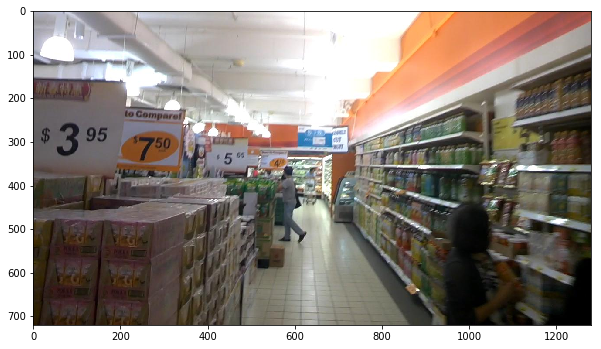

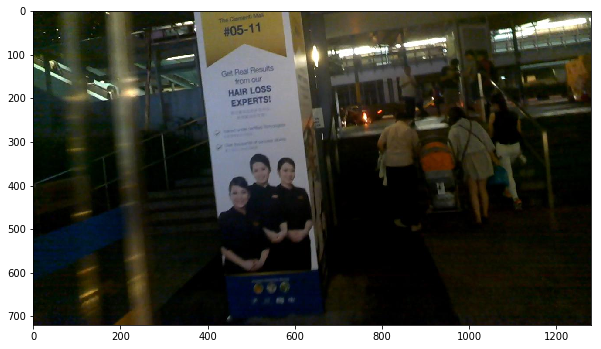

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img1 = cv2.imread(data1["img_path"])
img2 = cv2.imread(data1["ext_data"][0]["img_path"])
plt.figure(figsize=(10,6))
plt.imshow(img1[:,:,::-1])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(img2[:,:,::-1])
plt.show()


* Draw the updated label detection box, as shown below, where the red box is the original label information, and the blue box is the label box supplemented by CopyPaste.

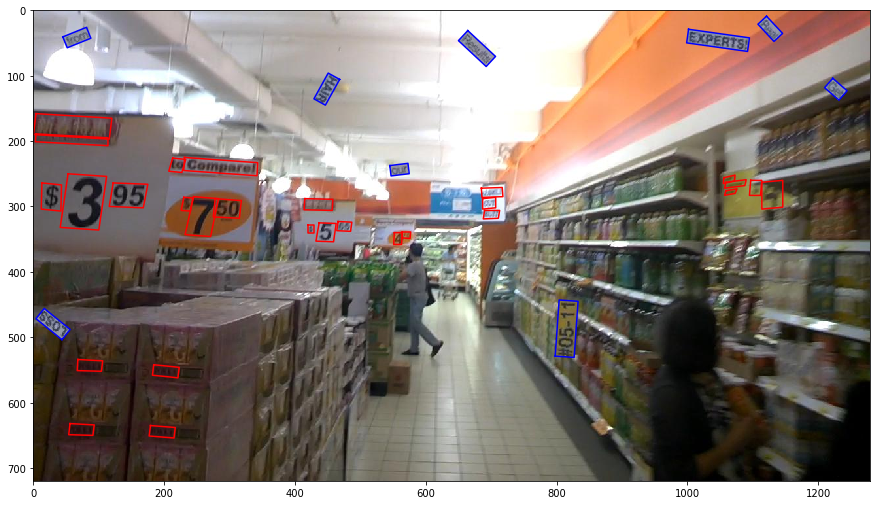

In [ ]:
import json
infos = copy_paste_demo.data_lines[idx]
infos = json.loads(infos.decode('utf-8').split("\t")[1])

img3 = data1["image"].copy()
plt.figure(figsize=(15,10))
plt.imshow(img3[:,:,::-1])
# 原始标注信息
for info in infos:
    xs, ys = zip(*info["points"])
    xs = list(xs)
    ys = list(ys)
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs, ys, "r")
# 新增的标注信息
for poly_idx in range(len(infos), len(data1["polys"])):
    poly = data1["polys"][poly_idx]
    xs, ys = zip(*poly)
    xs = list(xs)
    ys = list(ys)
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs, ys, "b")
plt.show()

### 3.1.3 Summary of Text Detection Optimization


In PP-OCRv2, the knowledge distillation scheme and data augmentation strategy are adopted for the text detection model to increase the generalization performance of the model. In the case of the final text detection model with the same size, Hmean increased from **0.759** to **0.795**. The specific ablation experiment is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/71c31fc78946459d9b2b0a5aeae75e9bf784399a73554bc79f8c25716ed9dcbe" width = "1200" />
</div>
<center>Figure 33: PP-OCRv2 detection model ablation experiment</center>

The detection detection result of PP-OCRv2 is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/5f1a7e4d193e439bb7b10b89460d76c5ee1e2787ea304641834677524c210795" width = "1000" />
</div>
<center>Figure 34: The detection result of PP-OCRv2</center>

## 3.2 Detailed Explanation of Text Recognition Model Optimization

In the process of PP-OCRv2 text recognition model optimization, techniques such as backbone network optimization, UDML knowledge distillation strategy, and CTC loss improvement are used to finally increase the recognition accuracy from **66.7%** to **74.8%**. The specific ablation experiments are as follows Shown.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b45a54b41d554858a8714e308c31863354fc544582704583b84205c95cba37c3" width = "1000" />
</div>
<center>Figure 35: PP-OCRv2 recognition model ablation experiment</center>

### 3.2.1 PP-LCNet Lightweight Backbone Network

Baidu proposed a lightweight CPU network based on MKLDNN acceleration strategy, namely PP-LCNet, which greatly improves the performance of lightweight models on image classification tasks. For downstream tasks of computer vision, such as text recognition, target detection, Semantic segmentation, etc., have a good performance. It should be noted here that PP-LCNet is customized and optimized for the **CPU+MKLDNN** scenario. The speed and accuracy of the classification task are far better than other models, so if you have model requirements for this use scenario If it is, I also recommend everyone to use it.

PP-LCNet paper address: [PP-LCNet: A Lightweight CPU Convolutional Neural Network](https://arxiv.org/abs/2109.15099)

PP-LCNet is improved based on MobileNetV1, and its structure is shown below.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/4d3794e3dd96464b80a3b50a80c7460761bdb1fbea2b4049a744f12d9bef9204" width = "1000" />
</div>
<center>Figure 36: PP-LCNet structure</center>

Compared with MobileNetV1, PP-LCNet integrates the activation function, head structure, SE module and other strategy optimization techniques in the MobileNetV3 structure. At the same time, it analyzes the convolution kernel size of the convolution layer in the final stage. In the end, the model is able to guarantee the speed advantage. Based on this, the accuracy greatly exceeds that of lightweight models such as MobileNet and GhostNet.

Specifically, PP-LCNet CCP involves the following 4 optimization points.

* Except for the SE module, all relu activation functions in the network are replaced with h-swish, and the accuracy is improved by 1%-2%
* In the fifth stage of PP-LCNet, the kernel size of DW becomes 5x5, and the accuracy is improved by 0.5%-1%
* The last two DepthSepConv blocks of the fifth stage of PP-LCNet add SE modules, and the accuracy is increased by 0.5%-1%
* Add a 1280-dimensional FC layer after GAP to increase feature expression capabilities and increase accuracy by 2%-3%


On the ImageNet1k data set, PP-LCNet compares to other currently more commonly used lightweight classification models, Top1-Acc and prediction time are as shown in the figure below. It can be seen that the prediction time and accuracy are better.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/91ac1cc5cf3e439d9bdff598a3fbac5dd059d324c5124dc0a1c1ad4c15b8cd9b" width = "800" />
</div>
<center>Figure 37: Comparison of state-of-the-art light networks over classification accuracy</center>

In the following way, the definition of the PP-LCNet recognition model can be quickly completed.

In [ ]:
# Reference Code
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/rec_mv1_enhance.py
from ppocr.modeling.backbones.rec_mv1_enhance import MobileNetV1Enhance

x = paddle.rand([1, 3, 23, 320])

model = MobileNetV1Enhance(scale=0.5)

y = model(x)
print(y.shape)

[1, 512, 1, 80]


### 3.2.2 U-DML Knowledge Distillation Strategy

For the standard DML strategy, the distilled loss function only includes the supervision of the final output layer. However, for two models with exactly the same structure, for the same input, their intermediate feature output expectations are also exactly the same, so in the final output layer In the supervision of supervision, the supervision signal of the intermediate output feature map can be further added as a loss function, that is, the U-DML (Unified-Deep Mutual Learning) knowledge distillation method in PP-OCRv2.

The algorithm flow chart of U-DML knowledge distillation is shown below. The network structure of the Teacher model and the Student model are exactly the same, and the initialization parameters are different. In addition, on the basis of the standard DML knowledge distillation, a new supervision mechanism for Feature Map has been introduced, and Feature Loss has been added.

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/15c3365ce87a49e4a26f91c93ab828470bceea1941aa47cf80fa7173cbcfcbd8" width = "1000" />
</div>
<center>Figure 38: The algorithm flow chart of U-DML knowledge distillation</center>

In the training process, there are a total of 3 types of loss: GT loss, DML loss, Feature loss.

* GT loss

The model structure used in the text recognition task is CRNN, so CTC loss is used as GT loss. The GT loss calculation method is as follows.

$$ Loss_{ctc} = CTC(S_{hout}, gt) + CTC(T_{hout}, gt) $$

* DML loss

The DML loss calculation method is as follows, where the Teacher model and the Student model calculate the KL divergence each other, and the final DML loss has symmetry.

$$ Loss_{dml} = \frac{KL(S_{pout} || T_{pout}) + KL(T_{pout} || S_{pout})}{2} $$

* Feature loss

Feature loss uses L2 loss, and the specific calculation method is shown below.

$$ Loss_{feat} = L2(S_{bout}, T_{bout}) $$

Finally, the calculation method of loss function during training is as follows.

$$ Loss_{total} = Loss_{ctc} + Loss_{dml} + Loss_{feat} $$


In addition, during the training process, by increasing the number of iterations, adding tricks such as the FC layer to the Head part, balance the feature encoding and decoding capabilities of the model, and further enhance the model effect.


The configuration file is in[ch_PP-OCRv2_rec_distillation.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_distillation.yml)。

```yaml
Architecture:
  model_type: &model_type "rec" # Model category, rec, det, etc., the model category of each sub-network is related to
  name: DistillationModel # Structure name, in the distillation task, DistillationModel, used to construct the corresponding structure
  algorithm: Distillation # Algorithm name
  Models: # Models, including the configuration information of the subnet
    Teacher: # The name of the sub-network, at least it must contain the information of `pretrained` and `freeze_params`, and the other parameters are the construction parameters of the sub-network
      pretrained: # Whether the sub-network needs to load a pre-trained model
      freeze_params: false # Do you need fixed parameters
      return_all_feats: true # The parameter of the subnet indicates whether all features need to be returned, if it is False, only the final output is returned
      model_type: *model_type # Model category
      algorithm: CRNN # The algorithm name of the sub-network. The remaining participation of the sub-network is the construction parameter, which is consistent with the general model training configuration
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96 # Intersperse a layer in the head decoding process
        fc_decay: 0.00002
    Student: # Another sub-network, here is a distillation example of DML, the two sub-networks have the same structure, and both need to learn parameters
      pretrained: # The following networking parameters are the same as above
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
```

Of course, if you want to add more sub-networks for training, you can also add the corresponding fields in the configuration file according to the way of adding `Student` and `Teacher`. For example, if you want 3 models to supervise each other and train together, then `Architecture` can be written in the following format.
```yaml
Architecture:
  model_type: &model_type "rec"
  name: DistillationModel
  algorithm: Distillation
  Models:
    Teacher:
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
    Student:
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
    Student2:                       # The new sub-network introduced in the knowledge distillation task, the other parts are the same as the above configuration
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
```

When the model is finally trained, it contains 3 sub-networks: `Teacher`, `Student`, and `Student2`.

The specific implementation code of the distillation model `DistillationModel` class can refer to [distillation_model.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.3/ppocr/modeling/architectures/distillation_model.py).

The final output of the model `forward` is a dictionary, the key is the name of all the subnets, for example, here are `Student` and `Teacher`, and the value is the output of the corresponding subnet, which can be `Tensor` (only returns the last one of the network) Layer) and `dict` (also returns the characteristic information in the middle).

In the recognition task, in order to add more loss functions and ensure the scalability of the distillation method, the output of each sub-network is saved as a `dict`, which contains the sub-module output. Take this recognition model as an example, the output result of each subnet is `dict`, the key includes `backbone_out`, `neck_out`, `head_out`, and `value` is the tensor of the corresponding module. Finally, for the above configuration file, The output format of `DistillationModel` is as follows.

```json
{
  "Teacher": {
    "backbone_out": tensor,
    "neck_out": tensor,
    "head_out": tensor,
  },
  "Student": {
    "backbone_out": tensor,
    "neck_out": tensor,
    "head_out": tensor,
  }
}
```

In the knowledge distillation task, the loss function configuration is as follows.

```yaml
Loss:
  name: CombinedLoss # Loss function name, based on the name change, build a class for loss function
  loss_config_list: # Loss function configuration file list, a necessary function for CombinedLoss
  -DistillationCTCLoss: # CTC loss function based on distillation, inherited from standard CTC loss
      weight: 1.0 # The weight of the loss function. In loss_config_list, the configuration of each loss function must include this field
      model_name_list: ["Student", "Teacher"] # For the prediction results of the distillation model, extract the output of these two sub-networks and calculate the CTC loss with gt
      key: head_out # Take the tensor corresponding to the key in the subnet output dict
  -DistillationDMLLoss: # Distilled DML loss function, inherited from standard DMLLoss
      weight: 1.0 # weight
      act: "softmax" # Activation function, use activation function to process the input, it can be softmax, sigmoid or None, the default is None
      model_name_pairs: # The subnet name pairs used to calculate DML loss. If you want to calculate the DML loss of other subnets, you can continue to fill in the list below
      - ["Student", "Teacher"]
      key: head_out # Take the tensor corresponding to the key in the subnet output dict
  -DistillationDistanceLoss: # Distillation distance loss function
      weight: 1.0 # weight
      mode: "l2" # Distance calculation method, currently supports l1, l2, smooth_l1
      model_name_pairs: # Subnet name pairs used to calculate distance loss
      - ["Student", "Teacher"]
      key: backbone_out # Take the tensor corresponding to the key in the subnet output dict
```

Among the above loss functions, all distillation loss functions are inherited from the standard loss function class. The main functions are: Analyze the output of the distillation model, find the intermediate node (tensor) used to calculate the loss, and then use the standard loss function class To calculate.

Taking the above configuration as an example, the final distillation training loss function contains the following three parts.

-The final output (`head_out`) of `Student` and `Teacher` and the CTC loss of gt, with a weight of 1. Here, because both sub-networks need to update the parameters, both of them need to calculate the loss with gt.
-DML loss between `Student` and `Teacher`'s final output (`head_out`), with a weight of 1.
-The l2 loss between `Student` and `Teacher`'s backbone network output (`backbone_out`), with a weight of 1.

The `CombinedLoss` class is implemented as follows.

```python
class CombinedLoss(nn.Layer):
    """
    CombinedLoss:
        a combionation of loss function
    """

    def __init__(self, loss_config_list=None):
        super().__init__()
        self.loss_func = []
        self.loss_weight = []
        assert isinstance(loss_config_list, list), (
            'operator config should be a list')
        for config in loss_config_list:
            assert isinstance(config,
                              dict) and len(config) == 1, "yaml format error"
            name = list(config)[0]
            param = config[name]
            assert "weight" in param, "weight must be in param, but param just contains {}".format(
                param.keys())
            self.loss_weight.append(param.pop("weight"))
            self.loss_func.append(eval(name)(**param))

    def forward(self, input, batch, **kargs):
        loss_dict = {}
        loss_all = 0.
        for idx, loss_func in enumerate(self.loss_func):
            loss = loss_func(input, batch, **kargs)
            if isinstance(loss, paddle.Tensor):
                loss = {"loss_{}_{}".format(str(loss), idx): loss}

            weight = self.loss_weight[idx]

            loss = {key: loss[key] * weight for key in loss}

            if "loss" in loss:
                loss_all += loss["loss"]
            else:
                loss_all += paddle.add_n(list(loss.values()))
            loss_dict.update(loss)
        loss_dict["loss"] = loss_all
        return loss_dict
```

For a more specific implementation of `CombinedLoss`, please refer to: [combined_loss.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/losses/combined_loss.py). For more specific implementations of distillation loss functions such as `DistillationCTCLoss`, please refer to [distillation_loss.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/losses/distillation_loss.py).



For the distillation of the above three models, the Loss field also needs to be modified accordingly, while considering the loss between the three sub-networks, as shown below.

```yaml
Loss:
  name: CombinedLoss # Loss function name, based on the name change, build a class for loss function
  loss_config_list: # Loss function configuration file list, a necessary function for CombinedLoss
  -DistillationCTCLoss: # CTC loss function based on distillation, inherited from standard CTC loss
      weight: 1.0 # The weight of the loss function. In loss_config_list, the configuration of each loss function must include this field
      model_name_list: ["Student", "Student2", "Teacher"] # For the prediction results of the distillation model, extract the output of these three sub-networks and calculate the CTC loss with gt
      key: head_out # Take the tensor corresponding to the key in the subnet output dict
  -DistillationDMLLoss: # Distilled DML loss function, inherited from standard DMLLoss
      weight: 1.0 # weight
      act: "softmax" # Activation function, use activation function to process the input, it can be softmax, sigmoid or None, the default is None
      model_name_pairs: # The subnet name pairs used to calculate DML loss. If you want to calculate the DML loss of other subnets, you can continue to fill in the list below
      -["Student", "Teacher"]
      -["Student2", "Teacher"]
      -["Student", "Student2"]
      key: head_out # Take the tensor corresponding to the key in the subnet output dict
  -DistillationDistanceLoss: # Distillation distance loss function
      weight: 1.0 # weight
      mode: "l2" # Distance calculation method, currently supports l1, l2, smooth_l1
      model_name_pairs: # Subnet name pairs used to calculate distance loss
      -["Student", "Teacher"]
      -["Student2", "Teacher"]
      -["Student", "Student2"]
      key: backbone_out # Take the tensor corresponding to the key in the subnet output dict
```


In [33]:
# Download data
!wget -nc https://paddleocr.bj.bcebos.com/dataset/rec_data_lesson_demo.tar && tar -xf rec_data_lesson_demo.tar && rm rec_data_lesson_demo.tar
# # Download the pre-trained model
!wget -nc https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_train.tar && tar -xf ch_PP-OCRv2_rec_train.tar && rm ch_PP-OCRv2_rec_train.tar

!python tools/train.py -c configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_distillation.yml \
    -o Train.dataset.data_dir="./rec_data_lesson_demo/" \
    Train.dataset.label_file_list=["./rec_data_lesson_demo/train.txt"] \
    Train.loader.num_workers=0 \
    Train.loader.batch_size_per_card=64 \
    Eval.dataset.data_dir="./rec_data_lesson_demo/" \
    Eval.dataset.label_file_list=["./rec_data_lesson_demo/val.txt"] \
    Eval.loader.num_workers=0 \
    Optimizer.lr.values=[0.0001,0.00001] \
    Global.epoch_num=1 \
    Global.pretrained_model="./ch_PP-OCRv2_rec_train/best_accuracy"

--2021-12-24 22:30:18--  https://paddleocr.bj.bcebos.com/dataset/rec_data_lesson_demo.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 699098618 (667M) [application/x-tar]
Saving to: ‘rec_data_lesson_demo.tar’

rec_data_lesson_dem 100%[===================>] 666.71M  42.5MB/s    in 16s     

2021-12-24 22:30:34 (40.7 MB/s) - ‘rec_data_lesson_demo.tar’ saved [699098618/699098618]

--2021-12-24 22:30:41--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

### 3.2.3 Enhanced CTC Loss Improvement

The recognition difficulty often encountered in Chinese OCR tasks is that there are too many similar characters, which are easy to misunderstand. Drawing lessons from the idea in Metric Learning, introducing Center loss to further increase the distance between classes, the core formula is shown below.

$$ L = L_{ctc} + \lambda * L_{center} $$
$$ L_{center} =\sum_{t=1}^T||x_{t}-c_{y_{t}}||_{2}^{2} $$

Here $x_t$ represents the label at the time step $t$, and $c_{y_{t}}$ represents the center corresponding to the label $y_t$.

In Enhance CTC, the initialization of center also has a greater impact on the result. In PP-OCRv2, the specific steps of center initialization are as follows.

1. Train a network based on the standard CTC loss;
2. Extract the correct image set from the training set and mark it as G;
3. Input the pictures in G into the network one by one, and extract the corresponding relationship between $x_t$ and $y_t$ of the head output timing feature. The calculation method of $y_t$ is as follows:

$$ y_{t} = argmax(W * x_{t}) $$

4. Aggregate the $x_t$ corresponding to the same $y_t$, and take the average value as the initial center.


First need to be based on [configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec.yml ) Train a basic network

For more training steps about Center loss, please refer to: [Enhanced CTC Loss Usage Document](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/enhanced_ctc_loss.md)

Finally, use [configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_enhanced_ctc_loss.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/chance_PP-OCRv2_rec_ct ) For training, the command is as follows.

```shell
python tools/train.py -c configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_enhanced_ctc_loss.yml
```

The main improvement is the `Loss` field. Compared with the standard `CTCLoss`, `CenterLoss` is added. Configure the number of categories, feature dimensions, and center path.

```yaml
Loss:
  name: CombinedLoss
  loss_config_list:
  - CTCLoss:
      use_focal_loss: false
      weight: 1.0
  - CenterLoss:
      weight: 0.05
      num_classes: 6625
      feat_dim: 96
      center_file_path: "./train_center.pkl"
```

### 3.2.4 Summary of Text Recognition Optimization

In the process of optimizing the PP-OCRv2 text recognition model, the model was improved from the perspectives of backbone network, loss function, etc., and the knowledge distillation training method was introduced, which finally increased the recognition accuracy from **66.7%** to **74.8%** , The specific ablation experiment is shown below.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b45a54b41d554858a8714e308c31863354fc544582704583b84205c95cba37c3" width = "800" />
</div>
<center>Figure 39: PP-OCRv2 recognition model ablation experiment</center>

Based on the PP-OCRv2 text detection, the experimental results of the recognition model are as follows.

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/12bec5f8e2e94fedbf4f2851f182e6bc7a1cff80a31b4390bedfcfbb7d8d6a6d"  width = "800" />
</div>
<center>Figure 40: The text detection results of PP-OCRv2</center>

# 4 Summary

This chapter mainly introduces the optimization strategies of PP-OCR and PP-OCRv2.

PP-OCR uses a total of 19 strategies from backbone network, learning rate strategy, data augmentation, model tailoring and quantification, etc., to optimize and slim the model, and finally create a server-oriented PP-OCR server system and a mobile-oriented PP -OCR mobile system.

Compared with PP-OCR, PP-OCRv2 further optimizes the three aspects of backbone network, data augmentation, and loss function to solve the problems of poor end-to-side prediction efficiency, complex background, and misrecognition of similar characters. At the same time, it introduces The knowledge distillation training strategy further improves the accuracy of the model, and finally creates a text detection and recognition system with accuracy and speed far exceeding PP-OCR.

# 5 Assignment

For specific content, see the `Optimization Strategy Objective Questions` and `Optimization Strategy Practical Questions` in the compulsory course completion.